# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Activation, Input, Concatenate

import matplotlib.pyplot as plt
tf.random.set_seed(0)
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Loading Data

In [3]:
#TCGA_Unscaled = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed TCGA mRNA Data/TCGA_mRNA_Unscaled.csv", index_col=0)
mRNA_Unscaled = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed mRNA/mRNA_Unscaled.csv", index_col=0)

In [ ]:
#TCGA_GeneMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed TCGA mRNA Data/TCGA_mRNA_GeneMinMaxScaled.csv", index_col=0)
mRNA_GeneMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed mRNA/mRNA_GeneMinMaxScaled.csv", index_col=0)

In [ ]:
#TCGA_GeneRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed TCGA mRNA Data/TCGA_mRNA_GeneRobustScaled.csv", index_col=0)
mRNA_GeneRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed mRNA/mRNA_GeneRobustScaled.csv", index_col=0)

In [ ]:
#TCGA_LineMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed TCGA mRNA Data/TCGA_mRNA_LineMinMaxScaled.csv", index_col=0)
mRNA_LineMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed mRNA/mRNA_LineMinMaxScaled.csv", index_col=0)

In [ ]:
#TCGA_LineRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed TCGA mRNA Data/TCGA_mRNA_LineRobustScaled.csv", index_col=0)
mRNA_LineRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed mRNA/mRNA_LineRobustScaled.csv", index_col=0)

In [4]:
miRNA_Unscaled = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed miRNA/miRNA_Unscaled.csv", index_col=0)
miRNA_GeneMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed miRNA/miRNA_GeneMinMaxScaled.csv", index_col = 0)
miRNA_LineMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed miRNA/miRNA_LineMinMaxScaled.csv", index_col = 0)
miRNA_LineRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed miRNA/miRNA_LineRobustScaled.csv", index_col = 0)
miRNA_GeneRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed miRNA/miRNA_GeneRobustScaled.csv", index_col = 0)

In [5]:
Protein_Unscaled = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed Protein/Protein_Unscaled.csv", index_col=0)
Protein_GeneMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed Protein/Protein_GeneMinMaxScaled.csv", index_col = 0)
Protein_LineMinMax = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed Protein/Protein_LineMinMaxScaled.csv", index_col = 0)
Protein_LineRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed Protein/Protein_LineRobustScaled.csv", index_col = 0)
Protein_GeneRobust = pd.read_csv("/content/drive/MyDrive/Processed Data/Processed Protein/Protein_GeneRobustScaled.csv", index_col = 0)

# Variational Autoencoders

##Variational Autoencoder Functions


In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

## mRNA VAE

In [ ]:
input_data = Input(shape = (1705))
x = layers.BatchNormalization()(input_data)
x = layers.Dense(1100, activation='selu')(x)
x = layers.BatchNormalization()(input_data)
x = layers.Dense(500, activation='selu')(x)
x = layers.BatchNormalization()(input_data)
z_mean = layers.Dense(200, name="z_mean")(x)
z_log_var = layers.Dense(200, name="z_log_var", kernel_initializer="zeros")(x)
encoded_data = Sampling()([z_mean, z_log_var])
#encoded_data = layers.Dense(200, activation='selu')(x)
x = layers.BatchNormalization()(encoded_data)
x = layers.Dense(500, activation='selu')(encoded_data)
x = layers.BatchNormalization()(input_data)
x = layers.Dense(1100, activation='selu')(x)
output_data = layers.Dense(1705, activation="sigmoid")(x)
mRNAautoencoder = Model(input_data, output_data)
mRNA_VAE_encoder = Model(input_data, encoded_data)

In [ ]:
mRNAautoencoder.compile(optimizer="adam", loss=loss_func(z_mean, z_log_var), metrics = [tf.keras.metrics.MeanSquaredError()])

Change the x and y to whichever set is currently being trained.

In [ ]:
history = mRNAautoencoder.fit(x = train2, y=train2,
                epochs=2000,
                batch_size=100,
                shuffle=True,
                validation_split=0.

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [ ]:
mRNA_VAE_encoder.save("")

# Autoencoders

## mRNA Autoencoder

In [ ]:
mRNA_input_data = Input(shape = (1705)) #224
x = layers.Dense(1000, activation="selu")(mRNA_input_data)
x = layers.Dense(500, activation = "selu")(x)
mRNA_encoded_data = layers.Dense(150, activation="selu")(x)
x = layers.Dense(500, activation="selu")(mRNA_encoded_data)
x = layers.Dense(1000, activation="selu")(x)

#Use relu output lauer for either robust scaled or unscaled data. Use sigmoid for Minmax data.. 

#mRNA_decoded_data = layers.Dense(1705)(x)
mRNA_decoded_data = layers.Dense(1705, activation ="sigmoid")(x)

mRNA_autoencoder =  Model(mRNA_input_data, mRNA_decoded_data)
mRNA_encoder = Model(mRNA_input_data, mRNA_encoded_data)

In [ ]:
mRNA_autoencoder.compile(optimizer="adam", loss='mse', metrics = [])
mRNA_encoder.compile(optimizer="adam", loss='mse', metrics = [])

In [ ]:
history = mRNA_autoencoder.fit(
                #Change x and y based on tested datasrt

                x =mRNA_GeneMinMax, y=mRNA_GeneMinMax,
                #x =TCGA_Unscaled, y=TCGA_Unscaled,
                epochs=1028,
                batch_size= 512,
                shuffle=True,

                #For Validation set either use mRNA data if the autoencoder is training on TCGA data or no validation

                #validation_data=(mRNA_Unscaled, mRNA_Unscaled)
                )

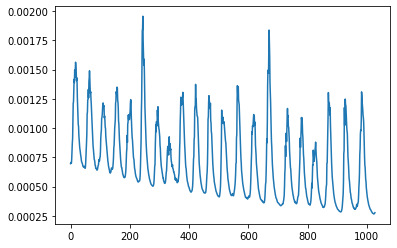

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

In [ ]:
mRNA_autoencoder.evaluate(x=mRNA_LineRobust, y=mRNA_LineRobust, batch_size=128)

In [ ]:
mRNA_encoder.save("/content/mRNA_GeneMinMax_encoder.h5", save_format="h5")

## miRNA Autoencoder

In [ ]:
miRNA_input_data = Input(shape = (224)) #224
x = layers.Dense(215, activation="selu")(miRNA_input_data)
x = layers.Dense(200, activation = "selu")(x)
miRNA_encoded_data = layers.Dense(150, activation="selu")(x)
x = layers.Dense(200, activation="selu")(miRNA_encoded_data)
x = layers.Dense(215, activation="selu")(x)

miRNA_decoded_data = layers.Dense(224)(x)
#miRNA_decoded_data = layers.Dense(224, activation ="sigmoid")(x)

miRNA_autoencoder =  Model(miRNA_input_data, miRNA_decoded_data)
miRNA_encoder = Model(miRNA_input_data, miRNA_encoded_data)

In [ ]:
miRNA_autoencoder.compile(optimizer="adam", loss='mse', metrics=[])
miRNA_encoder.compile(optimizer="adam", loss='mse', metrics=[])

In [ ]:
history = miRNA_autoencoder.fit(x=miRNA_LineRobust, y=miRNA_LineRobust,
                epochs=1028,
                batch_size=100,
                shuffle=True)

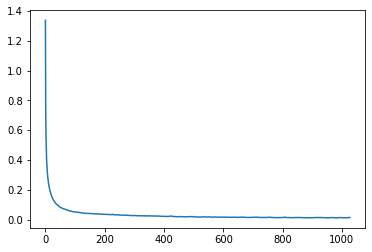

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
miRNA_autoencoder.evaluate(x=miRNA_GeneRobust, y=miRNA_GeneRobust, batch_size=128)

8/8 [==============================] - 0s 2ms/step - loss: 0.5994


0.5994499325752258

In [ ]:
miRNA_encoder.save("/content/miRNA_LineRobust_encoder.h5", save_format="h5")

## Protein Autoencoder


In [ ]:
Protein_input_data = Input(shape = (214)) 
x = layers.Dense(200, activation="selu")(Protein_input_data)
x = layers.Dense(175, activation = "selu")(x)
Protein_encoded_data = layers.Dense(150, activation="selu")(x)
x = layers.Dense(175, activation="selu")(x)
x = layers.Dense(200, activation="selu")(x)

#Protein_decoded_data = layers.Dense(214)(x)
Protein_decoded_data = layers.Dense(214, activation ="sigmoid")(x)

Protein_autoencoder =  Model(Protein_input_data, Protein_decoded_data)
Protein_encoder = Model(Protein_input_data, Protein_encoded_data)

In [ ]:
Protein_autoencoder.compile(optimizer="Adam", loss='mse', metrics = [])
Protein_encoder.compile(optimizer="Adam", loss='mse', metrics = [])

In [ ]:
history = Protein_autoencoder.fit(x=Protein_GeneMinMax, y=Protein_GeneMinMax,
                epochs=1028,
                batch_size=128,
                shuffle=True)

Epoch 1/1028


ValueError: ignored

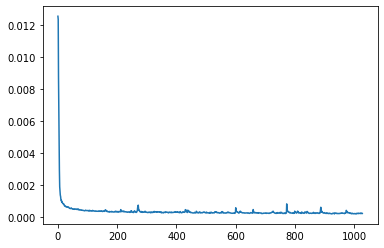

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
Protein_autoencoder.evaluate(x=Protein_Unscaled, y=Protein_Unscaled, batch_size=128)

8/8 [==============================] - 0s 3ms/step - loss: 0.0208


0.020845433697104454

In [ ]:
Protein_encoder.save("/content/Protein_GeneMinMax_encoder.h5", save_format="h5")

# Combined Autoencoders

In [6]:
mRNA_encoder = models.load_model("/content/drive/MyDrive/Models/Autoencoders/mRNA_Unscaled_encoder.h5")
miRNA_encoder = models.load_model("/content/drive/MyDrive/Models/Autoencoders/miRNA_Unscaled_encoder.h5")
Protein_encoder = models.load_model("/content/drive/MyDrive/Models/Autoencoders/Protein_Unscaled_encoder.h5")

In [7]:
mRNA_encoder.trainable = False
miRNA_encoder.trainable = False
Protein_encoder.trainable = False

In [8]:
#mRNA encoder
mRNA_input = Input(shape=(1705), name="mRNA")
mRNA_encoded = mRNA_encoder(mRNA_input, training=False)

#miRNA encoder
miRNA_input = Input(shape=(224), name="miRNA")
miRNA_encoded = miRNA_encoder(miRNA_input, training=False)

#ProteinRNA encoder
Protein_input = Input(shape=(214), name="Protein")
Protein_encoded = Protein_encoder(Protein_input, training=False)

Concatenation_layer = Concatenate()([mRNA_encoded, miRNA_encoded, Protein_encoded])
x = Dense(375, activation="selu")(Concatenation_layer)
x = Dense(325, activation="selu")(x)
encoded = Dense(300, activation="selu")(x)
x = Dense(325, activation="selu")(encoded)
x = Dense(375, activation="selu")(x)
output = Dense(450)(x)

Combined_autoencoder = Model([mRNA_input, miRNA_input, Protein_input], output)
Concatenator = Model([mRNA_input, miRNA_input, Protein_input], Concatenation_layer)
Combined_encoder = Model([mRNA_input, miRNA_input, Protein_input], encoded)

In [9]:
Combined_autoencoder.compile(optimizer="adam", loss='mse', metrics = [])
Concatenator.compile(optimizer="adam", loss='mse', metrics = [])
Combined_encoder.compile(optimizer="adam", loss='mse', metrics = [])

Change the term after mRNA_ to cahnge it to a different form of preprocessing

In [10]:
miRNA_Unscaled.reset_index(inplace=True)
Protein_Unscaled.reset_index(inplace=True)
mRNA_Unscaled.reset_index(inplace=True)

In [11]:
CellLines = list(set(mRNA_Unscaled.index.unique()) & set(Protein_Unscaled.index.unique()) & set(miRNA_Unscaled.index.unique()))

In [13]:
mRNA= mRNA_Unscaled[mRNA_Unscaled.index.isin(CellLines)].sort_values("index")
miRNA= miRNA_Unscaled[miRNA_Unscaled.index.isin(CellLines)].sort_values("index")
Protein= Protein_Unscaled[Protein_Unscaled.index.isin(CellLines)].sort_values("index")

In [14]:
mRNA.set_index("index", inplace=True)
miRNA.set_index("index", inplace=True)
Protein.set_index("index", inplace=True)

In [15]:
x = Concatenator.predict({"mRNA":mRNA, "miRNA":miRNA, "Protein":Protein})

In [23]:
history = Combined_autoencoder.fit(
                {"mRNA":mRNA, "miRNA":miRNA, "Protein":Protein}, 
                x,
                epochs=1028,
                batch_size=128,
                shuffle=True)


Epoch 1/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.0940
Epoch 2/1028
8/8 [==============================] - 0s 5ms/step - loss: 0.1007
Epoch 3/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.1012
Epoch 4/1028
8/8 [==============================] - 0s 5ms/step - loss: 0.0960
Epoch 5/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.0917
Epoch 6/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.0814
Epoch 7/1028
8/8 [==============================] - 0s 6ms/step - loss: 0.0721
Epoch 8/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.0696
Epoch 9/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.0641
Epoch 10/1028
8/8 [==============================] - 0s 5ms/step - loss: 0.0593
Epoch 11/1028
8/8 [==============================] - 0s 5ms/step - loss: 0.0625
Epoch 12/1028
8/8 [==============================] - 0s 4ms/step - loss: 0.0604
Epoch 13/1028
8/8 [==============================

KeyboardInterrupt: ignored

In [24]:
Combined_encoder.save("/content/Combined_Unscaled_encoder.h5", save_format="h5")